In [2]:
import sys, os
sys.path.append('../')
result_dir = os.path.join(os.path.dirname(os.getcwd()), 'result', 'ts')
figure_dir = os.path.join(os.path.dirname(os.getcwd()), 'figure')

from src.metric import MMD_heuristic, median_heuristic, c2st
from experiment.toggle_switch import calculate_cost
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.simulator.ts import ToggleSwitch


from torch import Tensor, nn
from torch.nn import functional as F
import torch
# from src.metric import maximum_mean_discrepancy, c2st
import matplotlib

plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

/opt/homebrew/anaconda3/envs/sbi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_list =  [10000, 500, 100]
T_list =  [50, 80, 300]
C = calculate_cost(n_list, T_list)
n_str = '_'.join([str(n) for n in n_list])
T_str = '_'.join([str(T) for T in T_list])

In [ ]:
mlmc_net = torch.load(os.path.join(result_dir, 'ts_MLMC_n_' + n_str + '_T_' + T_str + '.pt'))
mc_net_high = torch.load(os.path.join(result_dir, 'ts_MC_n_' + str(C // T_list[2]) + '_T_' + str(T_list[2]) + '.pt'))
mc_net_medium = torch.load(os.path.join(result_dir, 'ts_MC_n_' + str(C // T_list[1]) + '_T_' + str(T_list[1]) + '.pt'))
mc_net_low = torch.load(os.path.join(result_dir, 'ts_MC_n_' + str(C // T_list[0]) + '_T_' + str(T_list[0]) + '.pt'))

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_94258/423916957.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlmc_net = torch.load(os.path.join(result_dir,

In [ ]:

def obtain_density_over_grid(network: nn.Module, x_grid: Tensor, theta: Tensor):
    """
    network: nn.Module
    Input: x_grid [n_eval_points]
    theta: [theta_dim]
    """
    n_eval_points = x_grid.shape[0]
    return torch.stack([network.log_prob_unstandardized(x_grid[i], theta, log = False) for i in range(n_eval_points)]).squeeze(1).detach().numpy()

In [ ]:
n_eval_points = 1000
simulator = ToggleSwitch(sample_theta = True)
theta_star, x = simulator(n = 1, m = 1000, T = 300)
x_grid = torch.tensor(np.linspace(0, 2000, 1000))

In [ ]:
mlmc_density = obtain_density_over_grid(mlmc_net, x_grid, theta_star)
mc_density_high = obtain_density_over_grid(mc_net_high, x_grid, theta_star)
mc_density_medium = obtain_density_over_grid(mc_net_medium, x_grid, theta_star)
mc_density_low = obtain_density_over_grid(mc_net_low, x_grid, theta_star)

In [238]:
x_list = []
mlmc_density_list = []
mc_density_high_list = []
mc_density_medium_list = []
mc_density_low_list = []

for i in range(4):
    simulator = ToggleSwitch(sample_theta = True)
    theta_star, x = simulator(n = 1, m = 1000, T = 300)
    mlmc_density = obtain_density_over_grid(mlmc_net, x_grid, theta_star)
    mc_density_high = obtain_density_over_grid(mc_net_high, x_grid, theta_star)
    mc_density_medium = obtain_density_over_grid(mc_net_medium, x_grid, theta_star)
    mc_density_low = obtain_density_over_grid(mc_net_low, x_grid, theta_star)
    mlmc_density_list.append(mlmc_density)
    mc_density_high_list.append(mc_density_high)
    mc_density_medium_list.append(mc_density_medium)
    mc_density_low_list.append(mc_density_low)
    x_list.append(x)

In [241]:
data = {
    'x_list': x_list,
    'mlmc_density_list': mlmc_density_list,
    'mc_density_high_list': mc_density_high_list,
    'mc_density_medium_list': mc_density_medium_list,
    'mc_density_low_list': mc_density_low_list
}

# Save
import pickle
with open('ts_density_estimate.pkl', 'wb') as f:
    pickle.dump(data, f)

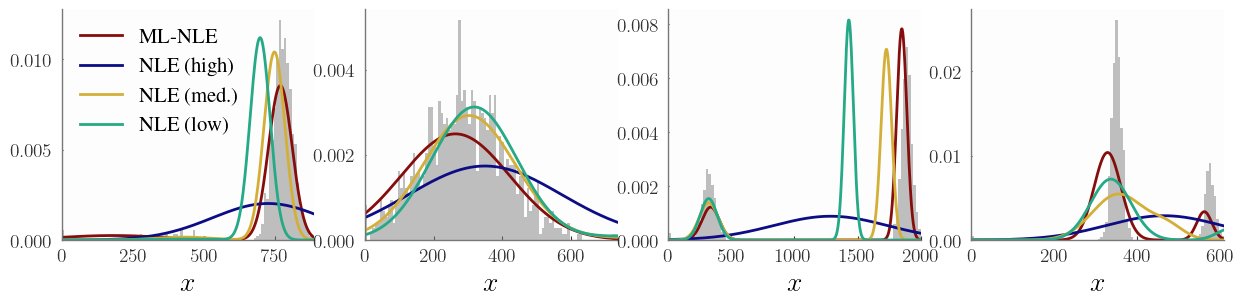

In [270]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3))
ax = ax.flatten()
colors = ["#850D0C", "#0C0C85", "#D4AF37", "#25A986"]

for i in range(4):

    ax[i].plot(x_grid, mlmc_density_list[i], label = 'ML-NLE', color = colors[0])
    ax[i].plot(x_grid, mc_density_high_list[i], label = 'NLE (high)', color = colors[1])
    ax[i].plot(x_grid, mc_density_medium_list[i], label = 'NLE (med.)', color = colors[2])
    ax[i].plot(x_grid, mc_density_low_list[i], label = 'NLE (low)', color = colors[3])
    ax[i].hist(x_list[i], bins = 100, density = True, alpha = 0.5, color = 'gray')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xlim(x_list[i].min(), x_list[i].max())
    ax[i].set_xlabel(r'$x$', fontsize = 20)

    if i == 0:
        ax[i].legend(frameon = False, fontsize = 15)

In [271]:
fig.savefig(os.path.join(figure_dir, 'ts_density.pdf'), bbox_inches = 'tight')

In [ ]:
n = 5000
m = 500
# simulator = ToggleSwitch(sample_theta = True)
# theta_test, x_test = simulator(n = n, m = m, T = 300)

In [17]:
# np.save(os.path.join(result_dir, 'ts_theta.npy'), theta_test)
# np.save(os.path.join(result_dir, 'ts_x.npy'), x_test)
theta_test = np.load(os.path.join(result_dir, 'ts_theta.npy'))
x_test = np.load(os.path.join(result_dir, 'ts_x.npy'))

In [27]:
theta_test = torch.tensor(theta_test)
x_test = torch.tensor(x_test)

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_94258/55442632.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_test = torch.tensor(theta_test)
/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_94258/55442632.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test)


In [19]:
network_list = [mlmc_net, mc_net_high, mc_net_medium, mc_net_low]
idx = 1
length_scale = median_heuristic(x_test[idx].unsqueeze(1))

In [275]:
x_test.shape

torch.Size([5000, 500])

In [104]:
mmd_mlmc = np.zeros((n, len(network_list)))

for i in range(n):
    x_test_i = x_test[i].unsqueeze(1)
    for j in range(len(network_list)):
        x_emu_i_j = network_list[j].sample_unstandardized(num_samples = m, condition = theta_test[i].unsqueeze(0)).squeeze(0)
        mmd_mlmc[i, j] = MMD_heuristic(x_test_i, x_emu_i_j, l_list = [length_scale])

In [ ]:
# np.save(os.path.join(result_dir, 'ts_mmd.npy'), mmd_mlmc)

In [20]:
mmd_mlmc = np.load(os.path.join(result_dir, 'ts_mmd.npy'))

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_94258/3024071354.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["ML-NLE", "NLE (high)", "NLE (med.)", "NLE (low)"], fontsize = 15, rotation = 90)


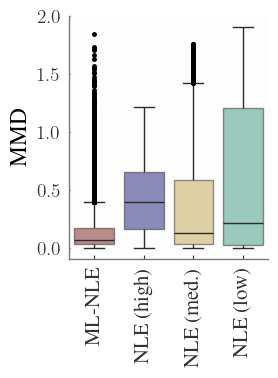

In [258]:
colors = ["#850D0C", "#0C0C85", "#D4AF37", "#25A986"]
f, ax = plt.subplots(figsize = (3, 4))
sns.boxplot(mmd_mlmc, palette = colors, ax = ax,
            flierprops={'marker': '.', 'color': 'black', 'markersize': 5, 'markerfacecolor': 'black', 'markeredgecolor': 'black'})
# sns.violinplot(mmd_mlmc, palette = colors, ax = ax, alpha = 0.5)

for patch in ax.patches:
    patch.set_alpha(0.5)

ax.set_xlabel('')
ax.set_ylabel('MMD', fontsize = 17)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(["ML-NLE", "NLE (high)", "NLE (med.)", "NLE (low)"], fontsize = 15, rotation = 90)
f.tight_layout()
# ax.set_yscale('log')
plt.show()

In [259]:
f.savefig(os.path.join(figure_dir, 'toggle_switch_mmd.pdf'), bbox_inches = 'tight')

In [172]:
f.savefig('figure/ts_mmd_comparison_3_level.pdf')

In [186]:
simulator = ToggleSwitch(sample_theta = True)
T_list = [50, 80, 300]

noises = simulator.noise_generator(n = 1, m = 1000, T = 300)
theta = simulator.prior(n = 1)
x_low = simulator.simulator(theta = theta, noises = [noises[0][:, :, 0:T_list[0], :], noises[1]])
x_med = simulator.simulator(theta = theta, noises = [noises[0][:, :, 0:T_list[1], :], noises[1]])
x_high = simulator.simulator(theta = theta, noises = [noises[0], noises[1]])


/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_94258/709836190.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


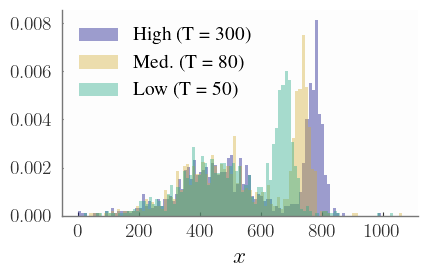

In [267]:
fig, ax = plt.subplots(1, 1, figsize = (4.5, 3))
ax.hist(x_high, bins = 100, density = True, alpha = 0.4, color = colors[1], label = 'High (T = 300)')
ax.hist(x_med, bins = 100, density = True, alpha = 0.4, color = colors[2], label = 'Med. (T = 80)')
ax.hist(x_low, bins = 100, density = True, alpha = 0.4, color = colors[3], label = 'Low (T = 50)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, fontsize = 14)
ax.set_xlabel(r'$x$', fontsize = 17)
fig.tight_layout()
fig.show()

In [268]:
fig.savefig(os.path.join(figure_dir, 'toggle_switch_high_med_low.pdf'), bbox_inches = 'tight')